In [1]:
# %%
import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--model_name', type=str, default='InceptionV3')
parser.add_argument('--weights', type=str, default='radimagenet')
parser.add_argument('--n_layers', type=int, default=4)
parser.add_argument('--n_neurons', type=int, default=256)
parser.add_argument('--n_dropout', type=float, default=0.0)
parser.add_argument('--lr_1', type=float, default=3e-4)
parser.add_argument('--lr_2', type=float, default=3e-6)
parser.add_argument('--image_size', type=int, default=512, required=False)
parser.add_argument('--batch_size', type=int, default=16, required=False)

args = parser.parse_args("")

model_name = args.model_name
weights = args.weights
n_layers = args.n_layers
n_neurons = args.n_neurons
n_dropout = args.n_dropout
lr_1 = args.lr_1
lr_2 = args.lr_2
img_size = args.image_size
batch_size = args.batch_size


In [2]:
# %%
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib.pylab as plt
from sklearn.metrics import roc_curve, roc_auc_score, recall_score
from tensorflow.keras.applications import InceptionResNetV2, ResNet50, InceptionV3, DenseNet121, Xception
import tensorflow_hub as hub
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score
import keras_cv


# %%
train_dir = '../data/split_1/train'
val_dir = '../data/split_1/val'
test_dir = '../data/split_1/test'


# %%
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, label_mode='binary', seed=0, image_size=(img_size, img_size), batch_size=batch_size, color_mode='rgb', crop_to_aspect_ratio=False)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(val_dir, label_mode='binary', seed=0, image_size=(img_size, img_size), batch_size=batch_size, color_mode='rgb', crop_to_aspect_ratio=False)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir, label_mode='binary', seed=0, image_size=(img_size, img_size), batch_size=1, color_mode='rgb', crop_to_aspect_ratio=False)


# %%
#Apply data augmentation
preprocessing_model = tf.keras.Sequential()
preprocessing_model.add(
    tf.keras.layers.experimental.preprocessing.RandomRotation(40))
# preprocessing_model.add(
#     tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2))
# preprocessing_model.add(
#     tf.keras.layers.experimental.preprocessing.RandomZoom(0.2, 0.2))
preprocessing_model.add(
    tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal"))
preprocessing_model.add(
    tf.keras.layers.experimental.preprocessing.RandomFlip(mode="vertical"))
#add cutmix augmentation
# preprocessing_model.add(keras_cv.augmentations.CutMix(batch_size=batch_size, img_size=img_size, n_classes=2, alpha=1.0, prob=0.5))
#add random cutout augmentation
preprocessing_model.add(keras_cv.layers.RandomCutout(0.5, 0.5))


# %%
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))


2023-02-14 14:35:58.775571: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-14 14:35:59.912689: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-14 14:35:59.912768: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-14 14:35:59.912777: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

You do not have pycocotools installed, so KerasCV pycoco metrics are not available. Please run `pip install pycocotools`.
You do not have pyococotools installed, so the `PyCOCOCallback` API is not available.
You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.
Found 492 files belonging to 2 classes.


2023-02-14 14:36:02.508886: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-14 14:36:04.060642: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18266 MB memory:  -> device: 0, name: NVIDIA RTX A4500, pci bus id: 0000:81:00.0, compute capability: 8.6
2023-02-14 14:36:04.061353: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 1247 MB memory:  -> device: 1, name: NVIDIA TITAN V, pci bus id: 0000:02:00.0, compute capability: 7.0


Found 165 files belonging to 2 classes.
Found 164 files belonging to 2 classes.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


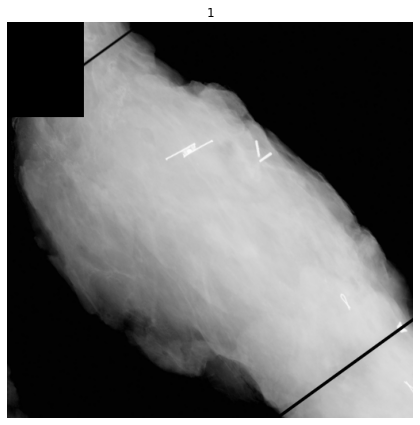

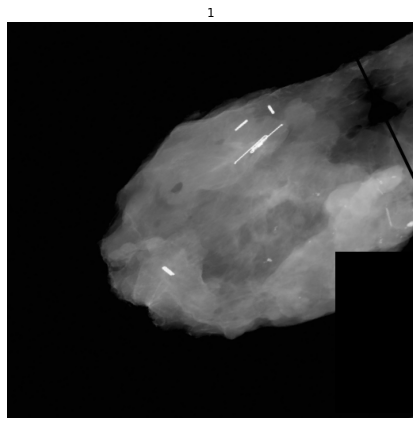

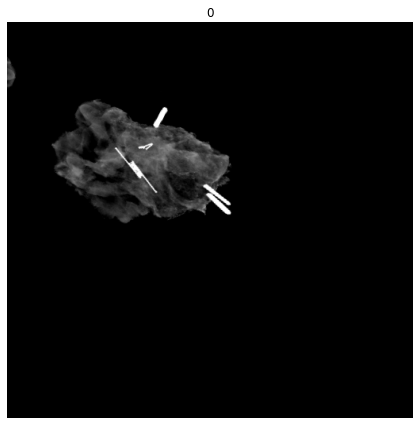

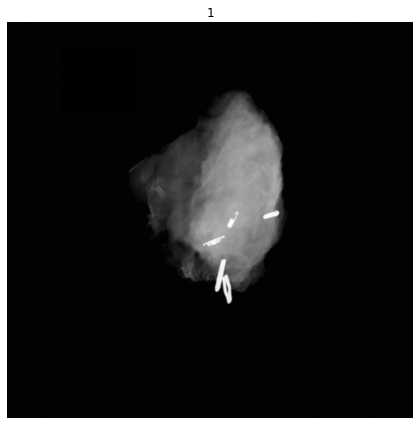

In [3]:
#view the first batch of images
# for images, labels in train_ds.take(1):
#     for i in range(4):
#         #make the plots bigger
#         plt.figure(figsize=(16, 16))
#         #define the number of rows and columns
#         rows = 2
#         columns = 2
#         #add subplot
#         plt.subplot(rows, columns, i + 1)
#         #plot the images
#         plt.imshow(images[i].numpy().astype("uint8"), aspect='auto')
#         plt.title(int(labels[i]))
#         plt.axis("off")

In [4]:
if model_name == 'InceptionV3':
    preprocess_fx = tf.keras.applications.inception_v3.preprocess_input
    model_dir = "../RadImageNet/models/RadImageNet-InceptionV3_notop.h5"
    if weights == 'radimagenet':
        base_model = InceptionV3(input_shape=(img_size, img_size, 3), include_top=False, weights=model_dir, pooling='avg')  


In [5]:
class myInceptionV3(tf.keras.Sequential):
    def __init__(self, input_shape=(img_size, img_size, 3), classes=1):
        super(myInceptionV3, self).__init__()
        self.base_model = [layer for layer in base_model.layers]
        self.classifier = tf.keras.layers.Dense(classes, activation='sigmoid')

    def call(self, inputs):
        x = inputs
        for layer in self.base_model:
            x = layer(x)
        x = self.classifier(x)
        return x
model = myInceptionV3()

In [6]:
model.build(input_shape=(None, img_size, img_size, 3))

ValueError: Input 0 of layer "conv2d_6" is incompatible with the layer: expected axis -1 of input shape to have value 192, but received input with shape (None, 61, 61, 64)

In [8]:
model.compile(
    optimizer=keras.optimizers.Adam(lr_1), 
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()],
)



ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [14]:
early_stopping = keras.callbacks.EarlyStopping(patience=5, min_delta=1e-10, restore_best_weights=True)
epochs = 1000
model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=early_stopping, verbose=1)
print('phase 1 complete')
# %%
#unfreeze all layers and train at lower learning rate
base_model.trainable = True
model.compile(
    optimizer=keras.optimizers.Adam(lr_2), 
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()],
)
model.fit(train_ds, epochs=1000, validation_data=val_ds, callbacks=early_stopping, verbose=1)
print('phase 2 complete')


Epoch 1/1000


2023-02-14 14:03:42.673643: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8800
2023-02-14 14:03:44.673503: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-02-14 14:03:44.675749: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-02-14 14:03:44.675764: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas
2023-02-14 14:03:44.675853: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation.

 1/31 [..............................] - ETA: 20:29 - loss: 312.9667 - binary_accuracy: 0.5625 - auc_2: 0.5000

2023-02-14 14:04:05.332576: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


31/31 [==============================] - 62s 685ms/step - loss: 29.4906 - binary_accuracy: 0.5142 - auc_2: 0.5013 - val_loss: 0.8970 - val_binary_accuracy: 0.5273 - val_auc_2: 0.5335
Epoch 2/1000
31/31 [==============================] - 16s 513ms/step - loss: 0.7279 - binary_accuracy: 0.5244 - auc_2: 0.5193 - val_loss: 0.7122 - val_binary_accuracy: 0.5333 - val_auc_2: 0.5379
Epoch 3/1000
31/31 [==============================] - 17s 519ms/step - loss: 0.7005 - binary_accuracy: 0.5305 - auc_2: 0.5357 - val_loss: 0.6918 - val_binary_accuracy: 0.5515 - val_auc_2: 0.5442
Epoch 4/1000
31/31 [==============================] - 17s 532ms/step - loss: 0.6933 - binary_accuracy: 0.5467 - auc_2: 0.5545 - val_loss: 0.6896 - val_binary_accuracy: 0.5333 - val_auc_2: 0.5485
Epoch 5/1000
31/31 [==============================] - 17s 524ms/step - loss: 0.6845 - binary_accuracy: 0.5610 - auc_2: 0.5683 - val_loss: 0.6843 - val_binary_accuracy: 0.5394 - val_auc_2: 0.5664
Epoch 6/1000
31/31 [=================

In [ ]:
# # %%
# #load test set and normalize using same code

# y_val_pred = np.array([])
# y_val = np.array([])
# for images, labels in val_ds:
#     y_val = np.append(y_val, labels.numpy())
#     y_val_pred = np.append(y_val_pred, model.predict(images))
# auroc_val = roc_auc_score(y_val, y_val_pred)

# y_test_pred = np.array([])
# y_test = np.array([])
# for images, labels in test_ds:
#     y_test = np.append(y_test, labels.numpy())
#     y_test_pred = np.append(y_test_pred, model.predict(images))
# auroc_test = roc_auc_score(y_test, y_test_pred)
# file_paths = test_ds.file_paths
# pred_df = pd.DataFrame({'file_path': file_paths, 'y_true': y_test, 'y_pred': y_test_pred})
# pred_df.to_csv('preds/preds_{}_{}.csv'.format(model_name, weights), index=False)

In [15]:
#save the final model as a .h5 file
model.save('models/{}_{}_grad.h5'.format(model_name, weights))

In [ ]:
#generate predictions for all images in the dataset, including train and val, and save to one csv
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, label_mode='binary', seed=0, shuffle=False, image_size=(img_size, img_size), batch_size=batch_size, color_mode='rgb')
val_ds = tf.keras.preprocessing.image_dataset_from_directory(val_dir, label_mode='binary', seed=0, shuffle=False, image_size=(img_size, img_size), batch_size=batch_size, color_mode='rgb')
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir, label_mode='binary', seed=0, shuffle=False, image_size=(img_size, img_size), batch_size=1, color_mode='rgb')
y_train_pred = np.array([])
y_train = np.array([])
for images, labels in train_ds:
    y_train = np.append(y_train, labels.numpy())
    y_train_pred = np.append(y_train_pred, model.predict(images))
train_file_paths = train_ds.file_paths

y_val_pred = np.array([])
y_val = np.array([])
for images, labels in val_ds:
    y_val = np.append(y_val, labels.numpy())
    y_val_pred = np.append(y_val_pred, model.predict(images))
val_file_paths = val_ds.file_paths

y_test_pred = np.array([])
y_test = np.array([])
for images, labels in test_ds:
    y_test = np.append(y_test, labels.numpy())
    y_test_pred = np.append(y_test_pred, model.predict(images))
test_file_paths = test_ds.file_paths

y_all_pred = np.append(y_train_pred, y_val_pred)
y_all_pred = np.append(y_all_pred, y_test_pred)
y_all = np.append(y_train, y_val)
y_all = np.append(y_all, y_test)
file_paths = np.append(train_file_paths, val_file_paths)
file_paths = np.append(file_paths, test_file_paths)
pred_df = pd.DataFrame({'file_path': file_paths, 'y_true': y_all, 'y_pred': y_all_pred})
pred_df.to_csv('../preds/preds_{}_{}_all_cutout.csv'.format(model_name, weights), index=False)


Found 492 files belonging to 2 classes.
Found 165 files belonging to 2 classes.
Found 164 files belonging to 2 classes.
1/1 [==============================] - 0s 48ms/step


In [ ]:
auroc_test = roc_auc_score(y_test, y_test_pred)
auroc_val = roc_auc_score(y_val, y_val_pred)
print("test auroc: {}".format(auroc_test))
print("val auroc: {}".format(auroc_val))


test auroc: 0.6949910554561717
val auroc: 0.6121426466254053


In [ ]:
results_df = pd.DataFrame({'model': [model_name], 'weights': [weights], 'image_size': [img_size], 'batch_size': [batch_size], 'lr_1': [lr_1], 'lr_2': [lr_2], 'n_layers': [n_layers], 'n_neurons': [n_neurons], 'n_dropout': [n_dropout], 'auroc_val': auroc_val, 'auroc_test': auroc_test})